# 파이토치로 구현하는 신경망

## 신경망 모델 구현하기

In [1]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [2]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

In [3]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

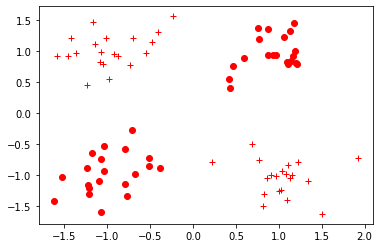

In [4]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [5]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])


In [6]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu = self.relu(linear1)
            linear2 = self.linear_2(relu)
            output = self.sigmoid(linear2)
            return output

In [7]:
model = NeuralNet(2, 5)
learning_rate = 0.03
criterion = torch.nn.BCELoss()
epochs = 2000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [8]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7506880164146423


오차값이 0.73 이 나왔습니다. 이정도의 오차를 가진 모델은 사실상 분류하는 능력이 없다고 봐도 무방합니다.
자, 이제 드디어 인공신경망을 학습시켜 퍼포먼스를 향상시켜 보겠습니다.

In [9]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7403848171234131
Train loss at 100 is 0.6366969347000122
Train loss at 200 is 0.5779969692230225
Train loss at 300 is 0.5095299482345581
Train loss at 400 is 0.4255966246128082
Train loss at 500 is 0.35197073221206665
Train loss at 600 is 0.29599490761756897
Train loss at 700 is 0.25384435057640076
Train loss at 800 is 0.22214634716510773
Train loss at 900 is 0.19830356538295746
Train loss at 1000 is 0.18022854626178741
Train loss at 1100 is 0.16633997857570648
Train loss at 1200 is 0.15549810230731964
Train loss at 1300 is 0.14690430462360382
Train loss at 1400 is 0.13998672366142273
Train loss at 1500 is 0.1343328058719635
Train loss at 1600 is 0.12965188920497894
Train loss at 1700 is 0.12573084235191345
Train loss at 1800 is 0.12241349369287491
Train loss at 1900 is 0.11958181858062744


In [10]:
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.08140307664871216


학습을 하기 전과 비교했을때 현저하게 줄어든 오차값을 확인 하실 수 있습니다.
지금까지 인공신경망을 구현하고 학습시켜 보았습니다.
이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [11]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-1.3662, -1.4085],
        [-1.0734, -1.1070],
        [ 1.6370,  1.5573],
        [-0.2746, -0.2897],
        [-1.1215, -1.1561]])), ('linear_1.bias', tensor([-0.3210, -0.2519, -0.2347,  1.4663, -0.2637])), ('linear_2.weight', tensor([[-1.8147, -1.3834, -2.1695,  1.5093, -1.5317]])), ('linear_2.bias', tensor([1.4932]))])


`save()` 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 model.pt 라는 파일이 생성됩니다. 아래 코드처럼 새로운 신경망 객체에 model.pt 속의 가중치값을 입력시키는 것 또한 가능합니다.

In [12]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.9754801988601685
